<a href="https://colab.research.google.com/github/amrios80/linear-regression-tutorial/blob/master/aptos/aptos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

MINE-4101: Applied Data Science  
Univerisdad de los Andes  

**Contexto de Negocio:** La empresa Inmobiliaria Metro Cuadrado domicialada en la ciudad de Bogota - Colombia, quiere brindar a sus clientes una herramienta que les permita estimar el valor de un apartamento de acuerdo a sus caracteristicas fisicas y de ubicacion. El valor estimado debe ser lo mas cercano posible a la realidad para evitar labores de peritaje en el proceso de compra.

**Identificacion de la solución:** La necesidad de negocio planteada puede solucionarse utilizando un algoritmo de manchine learning como regresion lineal dado que se requiere predicir un valor numerico (precio de venta) y contamos con informacion de mercado que nos indica el valor real de los apartamentos de acuerdo a sus caracteristicas.

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option('display.float_format', '{:.2f}'.format)

## **1. Carga de los datos**

In [3]:
dataset_url="https://github.com/amrios80/linear-regression-tutorial/raw/refs/heads/master/crabs/data/apartamentos.zip"
apto_df = pd.read_csv(dataset_url, compression="zip")

## **2. Entendimiento y limpieza de los datos**

Dado el contexto de negocio e interpretacion de los datos, se identifica que la variable PRECIO_VENTA es la variable objetivo del modelo de regresion lineal a desarrollar y se utilizaran todas las variables numericas, en cuanto a las variables categoricas consideraremos dentro del analisis SECTOR, ESTADO, ANTIGUEDAD previo conversion a valores numericos utilizando la tecnica de label encoding.

### **2.1 Entendimiento de los datos**

In [4]:
apto_df.shape

(43013, 46)

In [5]:
apto_df.dtypes

,0
_id,object
codigo,object
tipo_propiedad,object
tipo_operacion,object
precio_venta,float64
area,float64
habitaciones,float64
banos,float64
administracion,float64
parqueaderos,float64


In [6]:
apto_df.sample(3)

,_id,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,estado,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
41300,66d86e97ceda690e855128b4,2680-M5154689,APARTAMENTO,VENTA,180000000.00,45.00,3.00,1.00,NaN,0.00,FONTIBON TINTAL,2.00,REMODELADO,4.67,-74.16,NaN,"hermoso, iluminado y acogedor apartamento en v...",metrocuadrado.com,2024-08-18 15:03:59.185,2024-08-18 15:03:59.185,NaN,NaN,USADO,INMOBILIARIA INVERSIONES EUROPA LTDA,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,False,FONTIBON,PREDIO NARINO,Biblioteca Tintal,3105.74,0,PARQUE METROPOLITANO ZONA FRANCA,827.32,0
37563,66d86e44ceda690e85511a1b,5168-M3209561,APARTAMENTO,VENTA,895000000.00,91.17,3.00,2.00,580000.00,2.00,NIZA ALHAMBRA,4.00,ENTRE 0 Y 5 ANOS,4.71,-74.07,NaN,cod. ropa magnifico apartamento para estrena...,metrocuadrado.com,2024-08-13 13:03:58.395,2024-08-13 13:03:58.395,NaN,NaN,USADO,TU OFERTA INMOBILIARIA,NaN,0.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,False,SUBA,BATAN LOTE NIZA XII,Humedal Córdoba,162.92,1,PARQUE ZONAL LOS LACHES LA MINA,633.32,0
20232,66d86d1cceda690e8550d668,851-M2599321,APARTAMENTO,VENTA,3900000000.00,330.00,4.00,4.00,2000000.00,2.00,CHICO,6.00,ENTRE 10 Y 20 ANOS,4.68,-74.04,NaN,"exclusivo apartamento de 4 alcobas, balcones d...",metrocuadrado.com,2024-08-13 20:46:42.786,2024-07-07 12:13:40.639,NaN,[],USADO,ALTITUD GRUPO INMOBILIARIO S.A.S,NaN,0.00,NaN,NaN,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,False,CHAPINERO,CHICO RESERVADO,Calle 100 - Marketmedios,1817.20,0,PARQUE VECINAL URBANIZACIÓN LA CABRERA,1229.48,0


##### **2.1.1 Tipos de Operacion y Tipo de Propiedad**: Identificamos en el dataset operaciones diferentes a VENTA, exploramos las operaciones existentes y eliminamos la operacion ARRIENDO ya que no corresponde al objetivo del estudio, en cuanto al tipo de propiedad, se consideran los apartamentos y se excluyen las casas.

In [7]:
apto_df["tipo_operacion"].value_counts()

,count
tipo_operacion,
VENTA,27270
ARRIENDO,15515
VENTA Y ARRIENDO,228


In [8]:
apto_df=apto_df[(apto_df["tipo_operacion"] == "VENTA") | (apto_df["tipo_operacion"]=="VENTA Y ARRIENDO")]

In [9]:
apto_df["tipo_operacion"].value_counts()

,count
tipo_operacion,
VENTA,27270
VENTA Y ARRIENDO,228


In [10]:
apto_df["tipo_propiedad"].value_counts()

,count
tipo_propiedad,
APARTAMENTO,27428
CASA CON CONJUNTO CERRADO,60
CASA,10


In [11]:
apto_df=apto_df[(apto_df["tipo_propiedad"] == "APARTAMENTO")]

In [12]:
apto_df["tipo_propiedad"].value_counts()

,count
tipo_propiedad,
APARTAMENTO,27428


##### **2.1.2 Medidas de tendencia central y dispercion de la variable PRECIO_VENTA**: Identificamos que la variable precio tiene una alta dispersion ya que la desviacion estandar esta por encima de la media, los precios de venta en el dataset varian entre 1'000.000 y 4.250.000'000.000, es posible que el precio minimo corresponda a una inconsistencia en los datos ya que el valor es consecuente con un canon de arrendamiento mas no con el precio de venta de un apartamento, el precio maximo es muy alto con respecto al valor maximo del 75% de la oferta de apartamentos que es de 1.340'000.000

In [13]:
apto_df["precio_venta"].describe()

,precio_venta
count,27428.00
mean,2375589728.70
std,55900056661.84
min,1000000.00
25%,410000000.00
50%,710000000.00
75%,1350000000.00
max,4250000000000.00


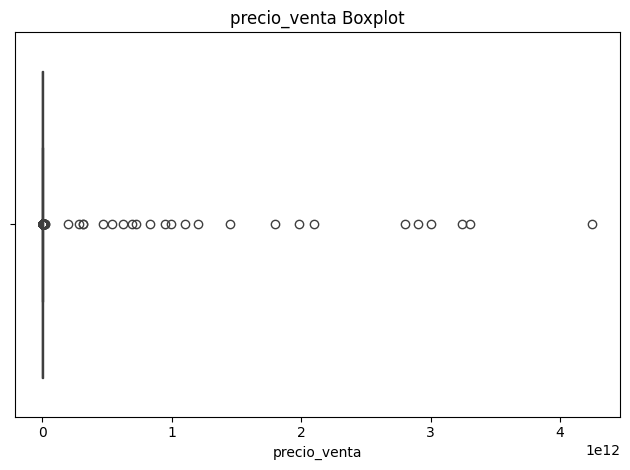

In [14]:
def boxplot(apto_df , field="precio_venta"):
  plt.xlabel(field)
  sns.boxplot(x=apto_df[field])
  plt.title(f'{field} Boxplot')
  plt.xlabel(field)
  plt.tight_layout()
  plt.show()

boxplot(apto_df, field="precio_venta")

##### **2.1.3 Eliminar valores atipicos de la variable PRECIO_VENTA**: Removiendo los valores atipicos los valores minimos y maximos fluctuan entre  171'500.000 COP y 1.570'000.000 COP, la desviacion estandar es menor que el promedio y el valor promedio de los apartamentos es de 676.955.510 COP consideramos que esta información esta mas acorde con la realidad del mercado.

In [15]:
def cut_outliers_from_df(df0 , field="precio_venta", iqr_pct=0.25):
  df=df0.copy()
  if pd.api.types.is_numeric_dtype(df[field]):
     q1 = df[field].quantile(0.25)
     q3 = df[field].quantile(0.75)
     iqr = q3 - q1
     lower_bound = q1 - (iqr_pct * iqr)
     upper_bound = q3 + (iqr_pct * iqr)
     df=df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]
  return df

In [16]:
df=cut_outliers_from_df(apto_df, field="precio_venta")
apto_df=df
apto_df["precio_venta"].describe()


,precio_venta
count,21070.00
mean,681246143.43
std,365767799.31
min,175000000.00
25%,389462500.00
50%,596300000.00
75%,904400000.00
max,1585000000.00


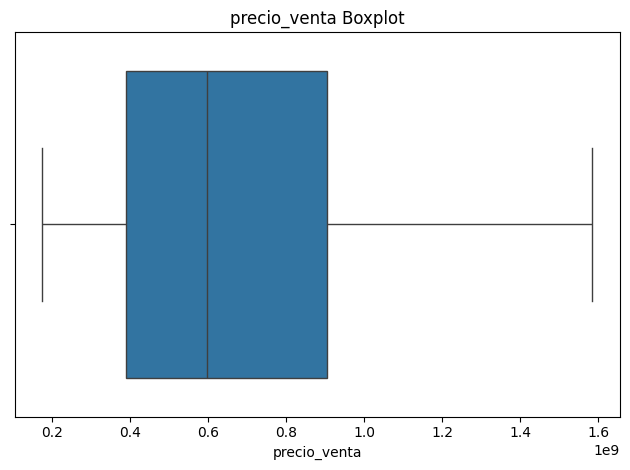

In [17]:
def boxplot(apto_df , field="precio_venta"):
  plt.xlabel(field)
  sns.boxplot(x=apto_df[field])
  plt.title(f'{field} Boxplot')
  plt.xlabel(field)
  plt.tight_layout()
  plt.show()

boxplot(apto_df, field="precio_venta")

##### **2.1.4 Exploracion variables categoricas ANTIGUEDAD, ESTADO y SECTOR**: Del total de la oferta de apartamentos en venta analizados (20.634), cerca del 65% tienen una antiguedad mayor a 10 años (13.277). El 1% de los apartamentos son NUEVOS. El 80% de la oferta de apartamentos se concentra en los siguientes sectores: SANTA BARBARA, CHICO, COLINA Y ALREDEDORES, COUNTRY, CEDRITOS, NIZA ALHAMBRA, CHAPINERO ALTO, ORQUIDEAS, SALITRE MODELIA, ALTOS DE SUBA Y CERROS DE SAN JORGE.

In [18]:
apto_df["antiguedad"].value_counts()

,count
antiguedad,
MAS DE 20 ANOS,7677
ENTRE 10 Y 20 ANOS,5558
ENTRE 0 Y 5 ANOS,3585
ENTRE 5 Y 10 ANOS,3335
REMODELADO,690
SOBRE PLANOS,106
EN CONSTRUCCION,96
PARA ESTRENAR,16


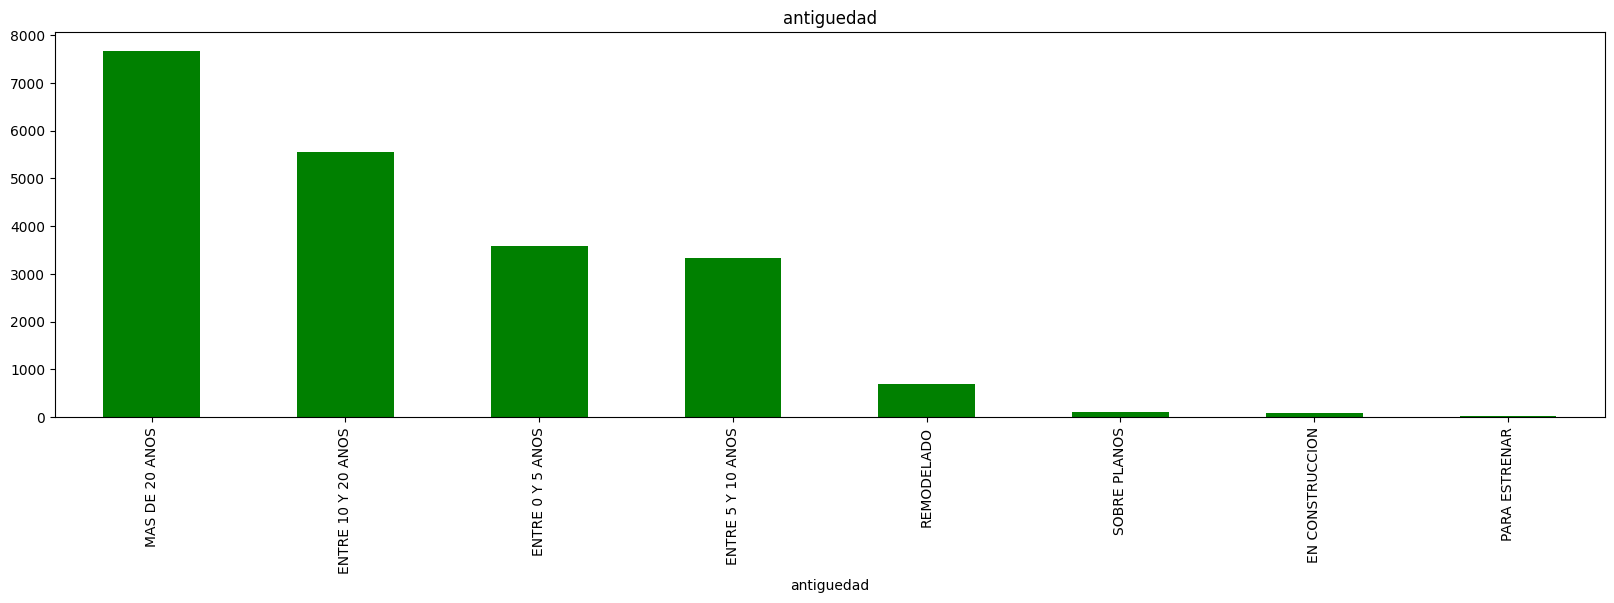

In [19]:
fig, (ax1) = plt.subplots(1, sharey=True, figsize=(20, 5))
apto_df["antiguedad"].value_counts().plot(kind="bar", ax=ax1, color="green")
ax1.set_title("antiguedad")
plt.show()

In [20]:
apto_df["estado"].value_counts()

,count
estado,
USADO,20422
NUEVO,218


In [21]:
sector_frec_cumsum = apto_df["sector"].value_counts(normalize=True).cumsum()
most_representative_sector = sector_frec_cumsum.loc[sector_frec_cumsum < 0.8].index.tolist()
most_representative_sector

['SANTA BARBARA',
 'CHICO',
 'COLINA Y ALREDEDORES',
 'COUNTRY',
 'CEDRITOS',
 'NIZA ALHAMBRA',
 'CHAPINERO ALTO',
 'ORQUIDEAS',
 'SALITRE MODELIA',
 'ALTOS DE SUBA Y CERROS DE SAN JORGE']

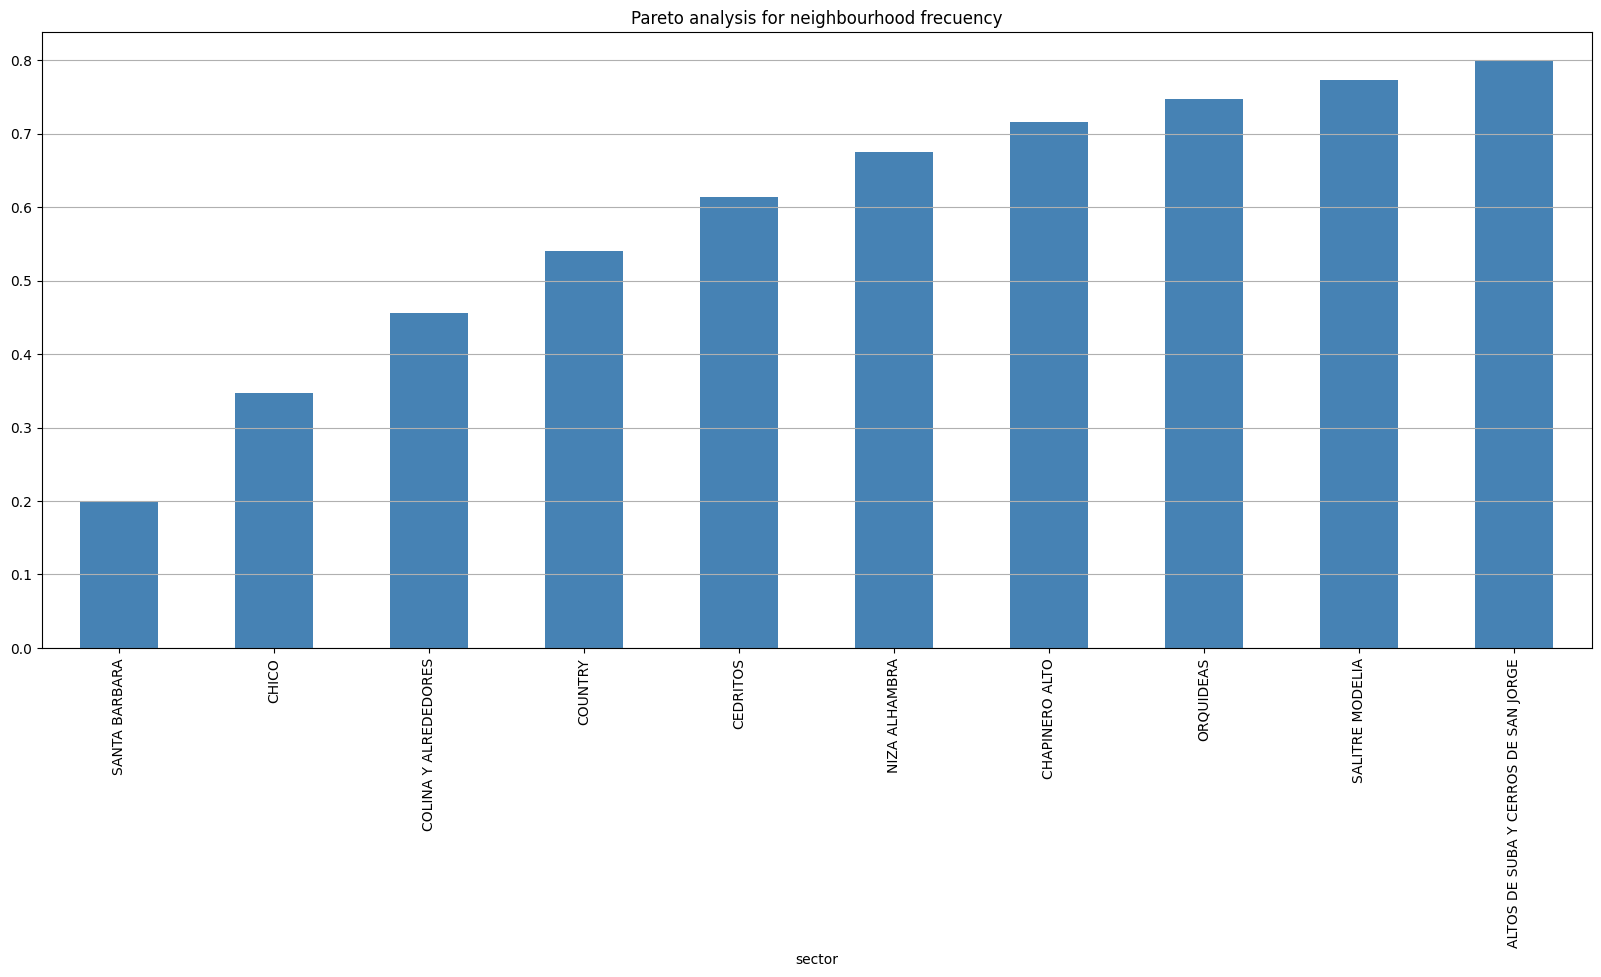

In [22]:
plt.figure(figsize=(20, 8))
sector_frec_cumsum.loc[sector_frec_cumsum < 0.8].plot(kind="bar", color="steelblue")
plt.title("Pareto analysis for neighbourhood frecuency")
plt.grid(axis="y")
plt.show()

##### **2.1.5 Crear dataset de entrada al modelo:** Se identifican las variables categoricas, numericas (features) y variable objetivo (target) para generar el dataset que se utilizara en el analisis. No se tienen en cuenta las variables de entrada que tienen similitud y/o que son representan el detalle de otra.

In [23]:
apto_df.sample(3)

,_id,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,estado,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
7686,66d86ca2ceda690e8550a566,495-M4525047,APARTAMENTO,VENTA,430000000.00,47.00,1.00,2.00,240000.00,1.00,CEDRITOS,4.00,ENTRE 0 Y 5 ANOS,4.72,-74.03,NaN,se vende hermoso apartamento en cedritos en p...,metrocuadrado.com,2024-08-03 02:05:42.727,2024-07-04 07:19:59.351,NaN,[],USADO,GESTIONES INMOBILIARIAS F.T. SAS,NaN,0.00,NaN,NaN,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,False,USAQUEN,ACACIAS USAQUEN,Calle 142,1987.07,0,PARQUE VECINAL NUEVA URBANIZACIÓN EL CEDRITO,72.44,1
39908,66d86e77ceda690e85512344,14983-M5013436,APARTAMENTO,VENTA,680000000.00,102.00,3.00,2.00,350000.00,2.00,COLINA Y ALREDEDORES,4.00,ENTRE 0 Y 5 ANOS,4.72,-74.06,NaN,"acogedor, amplio e iluminado apartamento en pi...",metrocuadrado.com,2024-08-23 02:49:36.884,2024-08-13 18:29:30.977,NaN,[],USADO,IVAN RODRIGO VELASQUEZ CANON,NaN,0.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,False,SUBA,SAN RAFAEL NORTE,Alcalá – Colegio S. Tomás Dominicos,1034.24,0,PARQUE VECINAL PRADO PINZÓN,813.52,0
24506,66d86d57ceda690e8550e71a,10278-M3549040,APARTAMENTO,VENTA,500000000.00,83.13,2.00,2.00,550000.00,0.00,CHAPINERO ALTO,5.00,MAS DE 20 ANOS,4.65,-74.06,NaN,acogedor apartamento en el piso 2 de la torre ...,metrocuadrado.com,2024-07-10 18:36:08.058,2024-07-10 18:36:08.058,NaN,NaN,USADO,REMAX COLOMBIA,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,False,CHAPINERO,S.C. CHAPINERO NORTE,Calle 63,673.46,0,PARQUE ZONAL GUSTAVO URIBE BOTERO,759.24,0


In [24]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], dtype=int)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res



In [25]:
apto_df_antes_encoding=apto_df.copy()


In [26]:
apto_df=apto_df_antes_encoding.copy()

In [27]:
apto_df.shape

(21070, 46)

In [28]:
for i in ["antiguedad","tipo_propiedad","estado"]:
  apto_df=encode_and_bind(apto_df, i)

In [29]:
apto_df.shape

(21070, 54)

In [30]:
apto_df.sample(3)

,_id,codigo,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque,antiguedad_EN CONSTRUCCION,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_PARA ESTRENAR,antiguedad_REMODELADO,antiguedad_SOBRE PLANOS,tipo_propiedad_APARTAMENTO,estado_NUEVO,estado_USADO
22048,66d86d34ceda690e8550dd80,3115-M4860223,VENTA,425000000.00,82.00,3.00,3.00,375000.00,1.00,NIZA ALHAMBRA,5.00,4.69,-74.06,NaN,"excelente apartamento exterior 82 mts., sala c...",metrocuadrado.com,2024-07-10 20:02:44.885,2024-07-07 18:20:32.473,NaN,[],ASESORAS INMOBILIARIAS,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,False,SUBA,S.C. PASADENA,Calle 106,632.26,0,PARQUE ZONAL CANAL CORDOBA,869.99,0,0,0,0,0,1,0,0,0,1,0,1
22144,66d86d35ceda690e8550dde0,12095-M4802613,VENTA,1350000000.00,194.00,3.00,4.00,1272000.00,3.00,CERROS DE SUBA,6.00,4.71,-74.08,NaN,"hermoso apartamento en monteazul, excelente vi...",metrocuadrado.com,2024-07-07 18:37:46.662,2024-07-07 18:37:46.663,NaN,NaN,VICUS TIENDA INMOBILIARIA SAS,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False,SUBA,NIZA SUBA - EL BALCON DE LINDARAJA,Niza - Calle 127,1044.70,0,PARQUE VECINAL AGRUPACIÓN DE VIVIENDA EN BALCO...,222.96,1,0,0,1,0,0,0,0,0,1,0,1
23711,66d86d4bceda690e8550e3ff,851-1299957,VENTA Y ARRIENDO,920000000.00,80.00,2.00,3.00,620000.00,2.00,CHICO,6.00,4.67,-74.05,NaN,"hermoso apartaestudio, 50 mts de terraza, exce...",metrocuadrado.com,2024-08-14 00:54:43.210,2024-07-08 01:24:21.221,NaN,[{'fecha': {'$date': '2024-07-08T01:24:21.221Z...,ALTITUD GRUPO INMOBILIARIO S.A.S,4100000.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,False,CHAPINERO,LA CABRERA,Calle 85,1388.15,0,PARQUE VECINAL URBANIZACIÓN LA CABRERA,333.08,1,0,0,1,0,0,0,0,0,1,0,1


In [31]:
apto_df.columns

Index(['_id', 'codigo', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'latitud', 'longitud', 'direccion', 'descripcion', 'website',
       'last_view', 'datetime', 'url', 'timeline', 'compañia',
       'precio_arriendo', 'jacuzzi', 'piso', 'closets', 'chimenea',
       'permite_mascotas', 'gimnasio', 'ascensor', 'conjunto_cerrado',
       'piscina', 'salon_comunal', 'terraza', 'vigilancia', 'coords_modified',
       'localidad', 'barrio', 'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm', 'parque_cercano', 'distancia_parque_m',
       'is_cerca_parque', 'antiguedad_EN CONSTRUCCION',
       'antiguedad_ENTRE 0 Y 5 ANOS', 'antiguedad_ENTRE 10 Y 20 ANOS',
       'antiguedad_ENTRE 5 Y 10 ANOS', 'antiguedad_MAS DE 20 ANOS',
       'antiguedad_PARA ESTRENAR', 'antiguedad_REMODELADO',
       'antiguedad_SOBRE PLANOS', 'tipo_propiedad_APARTAMENTO', 'estado_NUEVO',
       'est

In [32]:
numeric_vars = ["area", "habitaciones", "banos", "administracion", "parqueaderos", "estrato", "jacuzzi","piso","closets", "chimenea", "permite_mascotas","gimnasio", "ascensor","piscina","salon_comunal","terraza","vigilancia","distancia_estacion_tm_m","distancia_parque_m", "is_cerca_parque","conjunto_cerrado","antiguedad_EN CONSTRUCCION",
       "antiguedad_ENTRE 0 Y 5 ANOS", "antiguedad_ENTRE 10 Y 20 ANOS", "antiguedad_ENTRE 5 Y 10 ANOS", "antiguedad_MAS DE 20 ANOS","antiguedad_PARA ESTRENAR", "antiguedad_REMODELADO","antiguedad_SOBRE PLANOS","estado_NUEVO", "estado_USADO"]
category_vars = ["sector", "tipo_propiedad", "localidad","barrio","estacion_tm_cercana","parque_cercano"]
target_var="precio_venta"
features=numeric_vars# + category_vars

In [33]:
category_vars

['sector',
 'tipo_propiedad',
 'localidad',
 'barrio',
 'estacion_tm_cercana',
 'parque_cercano']

In [34]:
# Se define funcion para transformar las variables categoricas a numericas
#def get_df(df, target_var="target", numeric_vars=[], category_vars=[]):
 # df = df.copy()
 # label_encoder = LabelEncoder()
 # for col in category_vars:
 #     df[col] = label_encoder.fit_transform(df[col].astype(str))
 # df=df[ numeric_vars + category_vars+ [target_var]]
 # return df

In [35]:
# Se crea el dataset df con las variables de entrada mas la variable objetivo
df = apto_df[ numeric_vars + [target_var]]

In [36]:
df.sample(3)

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,conjunto_cerrado,antiguedad_EN CONSTRUCCION,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_PARA ESTRENAR,antiguedad_REMODELADO,antiguedad_SOBRE PLANOS,estado_NUEVO,estado_USADO,precio_venta
42193,188.00,3.00,4.00,1000000.00,2.00,6.00,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,275.50,1454.50,0,0.00,0,0,0,0,1,0,0,0,0,1,1300000000.00
21504,53.22,2.00,1.00,20000.00,0.00,3.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2848.47,506.24,0,0.00,0,0,0,0,1,0,0,0,0,1,185000000.00
3184,75.33,3.00,2.00,300000.00,1.00,4.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1274.84,667.97,0,1.00,0,0,0,0,1,0,0,0,0,1,369800000.00


##### **2.1.6 Eliminacion de columnas sin informacion, valores nulos del dataset y valores en 0 de la variable objetivo:**  Se identifican las columnas con valores nulos para hacer limpieza del dataset. Las variables de entrada piso y closets no traen informacion, no es posible realizar imputacion de datos por lo que se decide quitar estas columnas

In [37]:
# Encuentra el porcentaje de nulos por columna
df[[target_var]+features].isnull().sum() / df.shape[0]

,0
precio_venta,0.00
area,0.00
habitaciones,0.00
banos,0.00
administracion,0.09
parqueaderos,0.00
estrato,0.00
jacuzzi,0.00
piso,1.00
closets,1.00


In [38]:
df.sample(3)

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,conjunto_cerrado,antiguedad_EN CONSTRUCCION,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_PARA ESTRENAR,antiguedad_REMODELADO,antiguedad_SOBRE PLANOS,estado_NUEVO,estado_USADO,precio_venta
26889,93.00,3.00,2.00,330000.00,1.00,5.00,0.00,NaN,NaN,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1338.20,1001.66,0,1.00,0,0,0,0,1,0,0,0,0,1,420000000.00
6873,60.00,2.00,2.00,420000000.00,1.00,5.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,547.79,605.85,0,0.00,0,0,0,0,1,0,0,0,0,1,380000000.00
31175,43.00,2.00,1.00,130000.00,1.00,3.00,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,211.97,928.27,0,1.00,0,0,0,1,0,0,0,0,0,1,240000000.00


In [39]:
#Elimina las variables de entrada piso y closets
if "piso" in df.columns:
    df = df.drop(columns=['piso'])
    if "piso" in features:
        features.remove("piso")
if "closets" in df.columns:
    df = df.drop(columns=['closets'])
    if "closets" in features:
        features.remove("closets")

In [40]:
#Validamos que no existan las columnas eliminadas anteriormente
print(df.columns)

Index(['area', 'habitaciones', 'banos', 'administracion', 'parqueaderos',
       'estrato', 'jacuzzi', 'chimenea', 'permite_mascotas', 'gimnasio',
       'ascensor', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'distancia_estacion_tm_m', 'distancia_parque_m', 'is_cerca_parque',
       'conjunto_cerrado', 'antiguedad_EN CONSTRUCCION',
       'antiguedad_ENTRE 0 Y 5 ANOS', 'antiguedad_ENTRE 10 Y 20 ANOS',
       'antiguedad_ENTRE 5 Y 10 ANOS', 'antiguedad_MAS DE 20 ANOS',
       'antiguedad_PARA ESTRENAR', 'antiguedad_REMODELADO',
       'antiguedad_SOBRE PLANOS', 'estado_NUEVO', 'estado_USADO',
       'precio_venta'],
      dtype='object')


In [41]:
# Quita los valores nulos
df = df.dropna(subset=[target_var]+features)
df_clean = df.dropna()
df= df_clean
df.shape

(19235, 30)

In [42]:
# Quita los precios en cero.
df=df[df[target_var]>0]
df.shape

(19235, 30)

### **2.2. Búsqueda de relaciones con la variable objetivo**

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

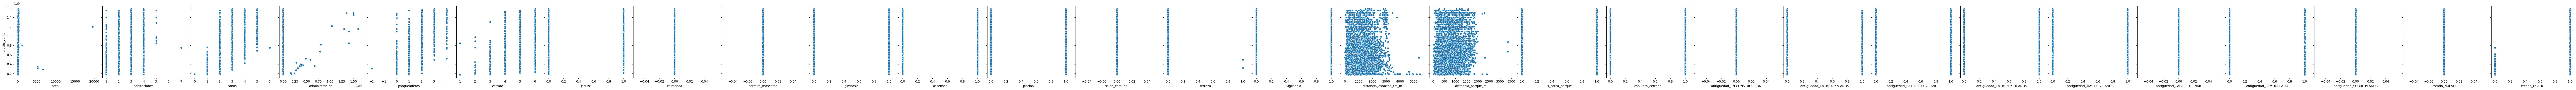

In [43]:
sns.pairplot(df.sample(frac=0.2), height=4, y_vars=target_var, x_vars=features, kind="scatter")


#####**2.2.1 Eliminacion de variables de entrada con valor 0:** Se eliminan las variables de entrada: salón comunal, permite mascotas, chimenea, antiguedad_SOBRE PLANOS, estado_NUEVO,antiguedad_PARA ESTRENAR, antiguedad_EN CONSTRUCCION,  ya que todos sus valores estan el 0.

In [44]:
if "tipo_propiedad" in df.columns:
    df = df.drop(columns=['tipo_propiedad'])
    if "tipo_propiedad" in features:
        features.remove("tipo_propiedad")
if "permite_mascotas" in df.columns:
    df = df.drop(columns=['permite_mascotas'])
    if "permite_mascotas" in features:
        features.remove("permite_mascotas")
if "chimenea" in df.columns:
    df = df.drop(columns=['chimenea'])
    if "chimenea" in features:
        features.remove("chimenea")
if "salon_comunal" in df.columns:
    df = df.drop(columns=['salon_comunal'])
    if "salon_comunal" in features:
        features.remove("salon_comunal")
if "salon_comunal" in df.columns:
    df = df.drop(columns=['salon_comunal'])
    if "salon_comunal" in features:
        features.remove("salon_comunal")
if "antiguedad_SOBRE PLANOS" in df.columns:
    df = df.drop(columns=['antiguedad_SOBRE PLANOS'])
    if "antiguedad_SOBRE PLANOS" in features:
        features.remove("antiguedad_SOBRE PLANOS")
if "estado_NUEVO" in df.columns:
    df = df.drop(columns=['estado_NUEVO'])
    if "estado_NUEVO" in features:
        features.remove("estado_NUEVO")
if "antiguedad_PARA ESTRENAR" in df.columns:
    df = df.drop(columns=['antiguedad_PARA ESTRENAR'])
    if "antiguedad_PARA ESTRENAR" in features:
        features.remove("antiguedad_PARA ESTRENAR")
if "antiguedad_EN CONSTRUCCION" in df.columns:
    df = df.drop(columns=['antiguedad_EN CONSTRUCCION'])
    if "antiguedad_EN CONSTRUCCION" in features:
        features.remove("antiguedad_EN CONSTRUCCION")


#####**2.2.2 Observacion variables de entrada Area y Administracion:** Se observan valores atípicos para las variables Area y Administracion y no permiten validar la correlacion entre estas variables y el precio de venta.

In [45]:
def cut_outliers_from_df(df0 , field="price", iqr_pct=0.6):
  df=df0.copy()
  print(f"Statistics for {field}:")
  print("before:")
  print(df[field].describe( percentiles=[0.25, 0.50, 0.75, 0.95]))
  if pd.api.types.is_numeric_dtype(df[field]):
     q1 = df[field].quantile(0.25)
     q3 = df[field].quantile(0.75)
     iqr = q3 - q1
     lower_bound = q1 - (iqr_pct * iqr)
     upper_bound = q3 + (iqr_pct * iqr)
     df=df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]
     print(f"after (iqr):")
     print(df[field].describe( percentiles=[0.25, 0.50, 0.75, 0.95]))
  return df

In [46]:
#Aplica la funcion cut_outliers_from_df para quitar outliers LO APLICA A TODAS LAS VARIABLES DE ENTRADA QUE SON DE INTERES
df2=cut_outliers_from_df(df, field="area")

Statistics for area:
before:
count   19235.00
mean      113.42
std       248.97
min         0.00
25%        67.24
50%        95.80
75%       140.00
95%       208.00
max     19621.00
Name: area, dtype: float64
after (iqr):
count   17354.00
mean       96.68
std        38.85
min        23.62
25%        65.00
50%        90.00
75%       125.20
95%       169.00
max       183.59
Name: area, dtype: float64


In [47]:
df2=cut_outliers_from_df(df2, field="administracion")
df=df2

Statistics for administracion:
before:
count        17354.00
mean       3129888.15
std       44906184.42
min              1.00
25%         310000.00
50%         500000.00
75%         795000.00
95%        1284070.00
max     1600000000.00
Name: administracion, dtype: float64
after (iqr):
count     15474.00
mean     501196.88
std      256756.54
min       20000.00
25%      300000.00
50%      465000.00
75%      692825.00
95%      980000.00
max     1086000.00
Name: administracion, dtype: float64


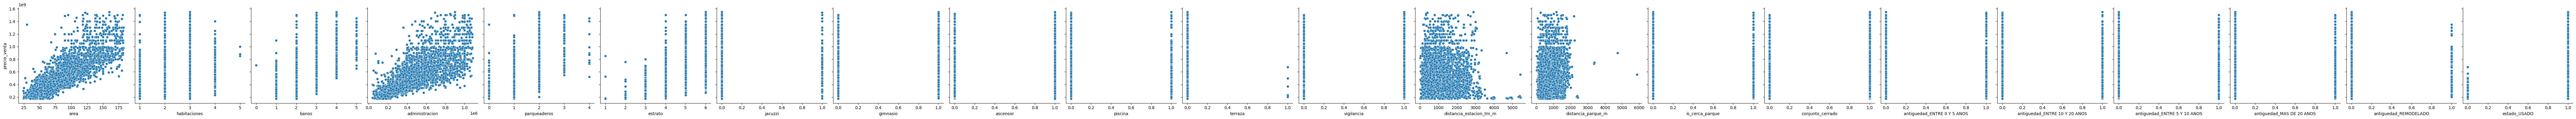

In [48]:
sns.pairplot(df.sample(frac=0.2), height=4, y_vars=target_var, x_vars=features, kind="scatter")

### **2.3 Búsqueda de relaciones entre las variables de entrada**

<Axes: >

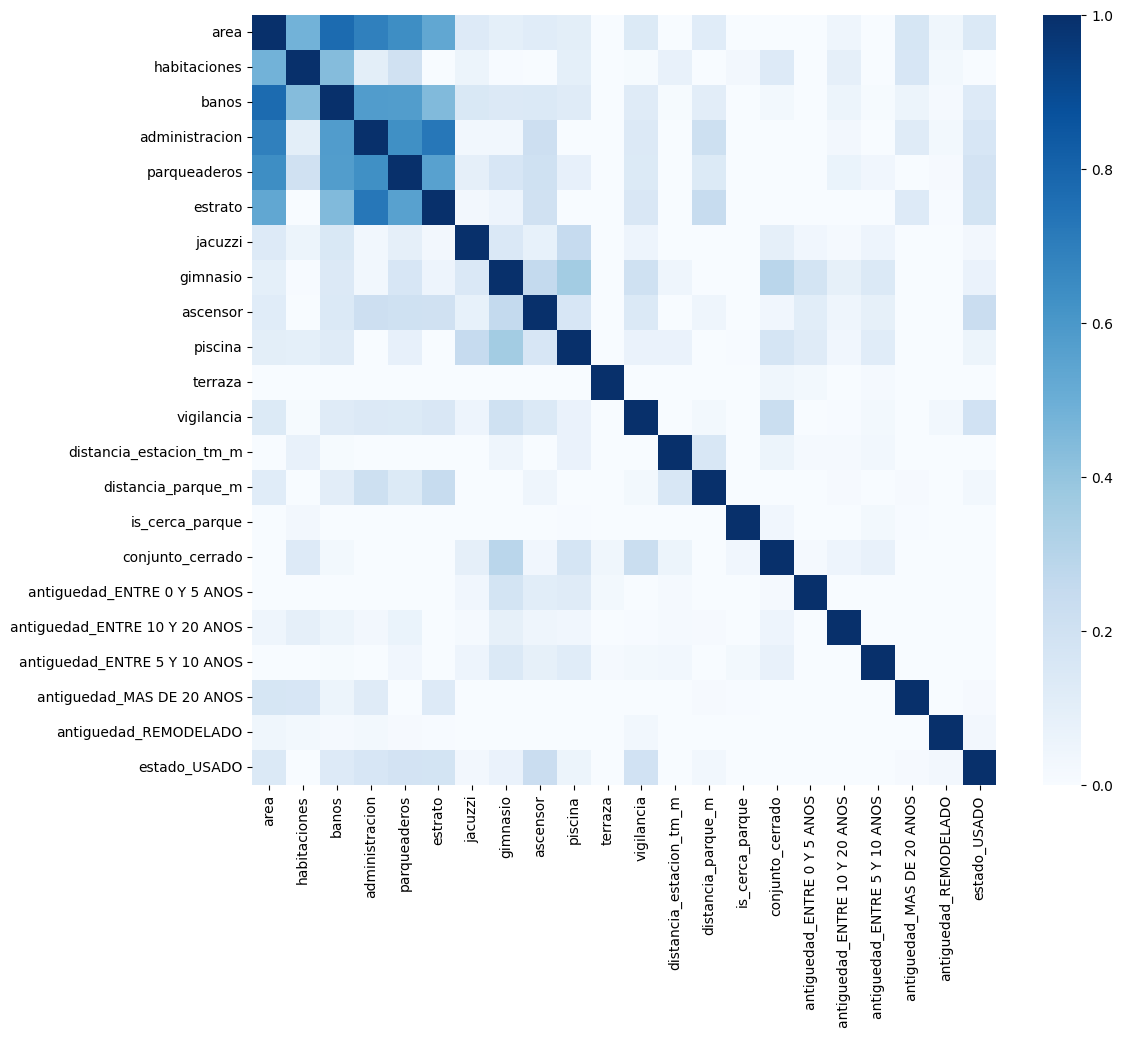

In [49]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[features].corr(), cmap="Blues", vmin=0, vmax=1)

In [50]:
df[features].corr()

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,gimnasio,ascensor,piscina,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,conjunto_cerrado,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_REMODELADO,estado_USADO
area,1.00,0.48,0.77,0.69,0.64,0.53,0.13,0.10,0.12,0.10,-0.03,0.14,-0.01,0.12,-0.07,-0.01,-0.23,0.04,-0.04,0.17,0.04,0.14
habitaciones,0.48,1.00,0.44,0.10,0.20,-0.10,0.06,0.01,-0.06,0.09,-0.02,0.01,0.08,-0.04,0.03,0.13,-0.27,0.09,-0.05,0.16,0.03,0.00
banos,0.77,0.44,1.00,0.58,0.58,0.45,0.15,0.14,0.14,0.12,-0.03,0.12,0.01,0.11,-0.06,0.02,-0.15,0.06,0.01,0.06,0.02,0.13
administracion,0.69,0.10,0.58,1.00,0.63,0.73,0.03,0.03,0.22,-0.03,-0.03,0.14,-0.04,0.21,-0.10,-0.13,-0.17,0.03,-0.03,0.12,0.02,0.16
parqueaderos,0.64,0.20,0.58,0.63,1.00,0.56,0.09,0.16,0.20,0.09,-0.03,0.14,-0.03,0.13,-0.08,-0.04,-0.12,0.06,0.04,0.00,0.01,0.19
estrato,0.53,-0.10,0.45,0.73,0.56,1.00,0.03,0.05,0.20,-0.03,-0.03,0.15,-0.02,0.25,-0.13,-0.16,-0.12,-0.02,-0.03,0.13,0.01,0.18
jacuzzi,0.13,0.06,0.15,0.03,0.09,0.03,1.00,0.15,0.08,0.25,-0.01,0.05,0.00,-0.01,-0.00,0.09,0.04,0.02,0.05,-0.08,-0.01,0.03
gimnasio,0.10,0.01,0.14,0.03,0.16,0.05,0.15,1.00,0.26,0.36,-0.01,0.21,0.05,-0.02,-0.02,0.29,0.18,0.09,0.14,-0.32,-0.08,0.07
ascensor,0.12,-0.06,0.14,0.22,0.20,0.20,0.08,0.26,1.00,0.16,-0.06,0.14,-0.00,0.05,-0.04,0.04,0.11,0.05,0.09,-0.19,-0.03,0.23
piscina,0.10,0.09,0.12,-0.03,0.09,-0.03,0.25,0.36,0.16,1.00,-0.01,0.07,0.07,-0.05,0.01,0.17,0.12,0.04,0.11,-0.21,-0.04,0.05


No se observa una fuerte correlacion entre las variables de entrada. El valor maximo de correlacion es de 0.77 entre la variable area y banos y es menor a 0.8 valor minimo de referencia para indicar correlación.

## **3. Preparacion de datos**


In [51]:
total_rows = df.shape[0]
total_rows

15474

In [52]:
df.loc[df.duplicated(subset=features, keep=False)].head(3)

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,gimnasio,ascensor,piscina,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,conjunto_cerrado,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_REMODELADO,estado_USADO,precio_venta
346,45.00,3.00,1.00,124209.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,942.74,659.25,0,1.00,0,0,1,0,0,0,195000000.00
492,58.00,3.00,2.00,206000.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,840.85,450.82,1,1.00,0,1,0,0,0,1,286000000.00
605,121.73,3.00,2.00,900000.00,1.00,6.00,0.00,0.00,1.00,0.00,0.00,1.00,1547.06,569.72,0,1.00,0,0,0,0,1,1,750000000.00


In [53]:
duplicated_rows = df.loc[df.duplicated(subset=features, keep=False)].shape[0]
duplicated_rows

761

In [54]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 4.9179%


In [55]:
df.loc[df.duplicated(subset=features+["precio_venta"], keep=False)].tail(4)

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,gimnasio,ascensor,piscina,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,conjunto_cerrado,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_REMODELADO,estado_USADO,precio_venta
42792,82.00,2.00,2.00,493000.00,2.00,6.00,0.00,0.00,1.00,0.00,0.00,0.00,1379.67,1545.63,0,0.00,0,0,0,1,0,1,480000000.00
42841,68.00,2.00,2.00,600000.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,372.65,615.56,0,0.00,0,1,0,0,0,1,480000000.00
42842,68.00,2.00,2.00,600000.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,372.65,615.56,0,0.00,0,1,0,0,0,1,480000000.00
42894,90.00,3.00,2.00,630000.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,1.00,1004.44,1010.14,0,1.00,0,0,0,1,0,1,450000000.00


In [56]:
duplicated_rows = df.loc[df.duplicated(subset=features+["precio_venta"], keep=False)].shape[0]
duplicated_rows

602

In [57]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 3.8904%


Existe un ~4.9% de registros con variables de entrada duplicadas, incluso con variable objetivo diferente. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el ~3.89% registros duplicados adicionales. Para un porcentaje total de ~8.8%, se decide eliminar los datos duplicados con el fin de no afectar en la funcion de estimacion.

In [58]:
df.drop_duplicates(subset=features, inplace=True)
df.drop_duplicates(subset=features+["precio_venta"], inplace=True)

In [59]:
df.shape

(15024, 23)

## **4. Particionamiento del conjunto de datos en entrenamiento y prueba**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df["precio_venta"], test_size=0.3, random_state=1)

In [61]:
X_train.shape, y_train.shape

((10516, 22), (10516,))

In [62]:
X_test.shape, y_test.shape

((4508, 22), (4508,))

## **5. Entrenamiento de un primer modelo de regresión lineal**

In [63]:
regression = LinearRegression()

In [64]:
regression.fit(X_train, y_train)

LinearRegression()

## **5.1. Interpretación de los coeficientes y del intercepto**


In [65]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

,columns,coef
0,area,4693468.59
1,habitaciones,-30510184.87
2,banos,18107264.46
3,administracion,239.24
4,parqueaderos,23541859.68
5,estrato,37331081.70
6,jacuzzi,6537204.02
7,gimnasio,36455562.29
8,ascensor,-4353037.43
9,piscina,19448207.57


In [66]:
regression.intercept_

2036927.8020858765

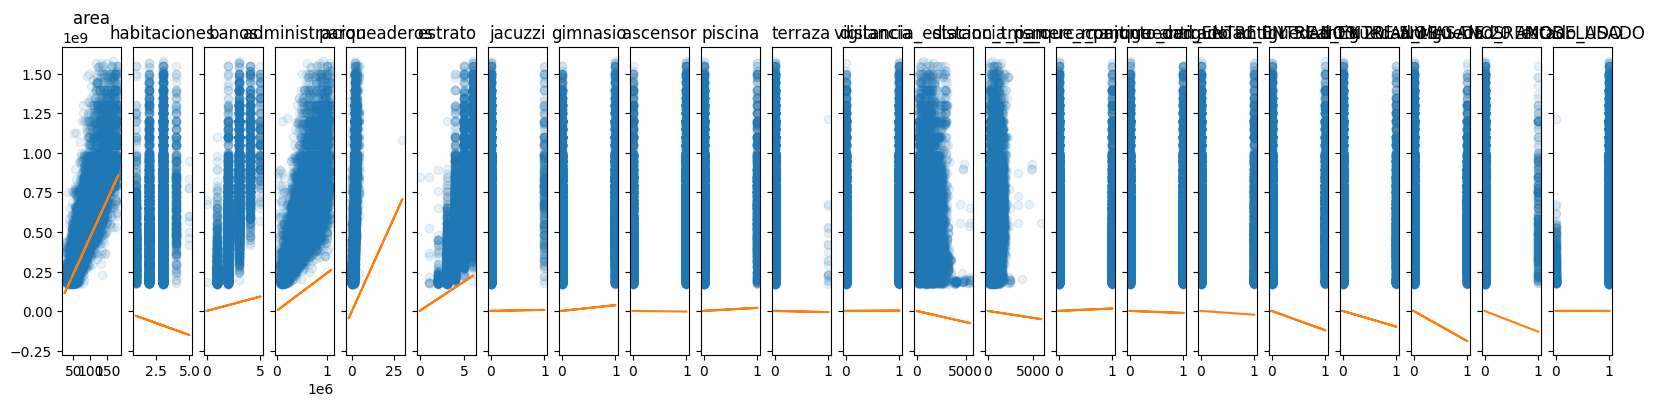

In [67]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Se observa que las variables con impacto negativo en la estimacion del precio de venta de un apartamento son antiguedad, ascensor, terraza,distancia_estacion_tm_m, distancia_parque_m, habitaciones, conjunto_cerrado, estado_USADO. Dentro de las variables de entrada con un impacto positivo en la estimacion del precio de venta son area, parqueaderos, estrato, jacuzzi, gimnasio y piscina. El valor del intercepto es de 2'036.927 sin embargo para el contexto de este ejercicio no aplica ya que no tiene sentido que no existan variables de entrada como el area para estimar un precio de venta.

## **5.2. Validación (evaluación) del modelo**

**Mean Absolute Error (MAE)**

In [68]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))



Train: 88940106.91003525
Test: 89289518.91277924


**Root Mean Squeared Error (RMSE)**

In [69]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 121626324.35766038
Test: 123033413.13263224


**Análisis del error**

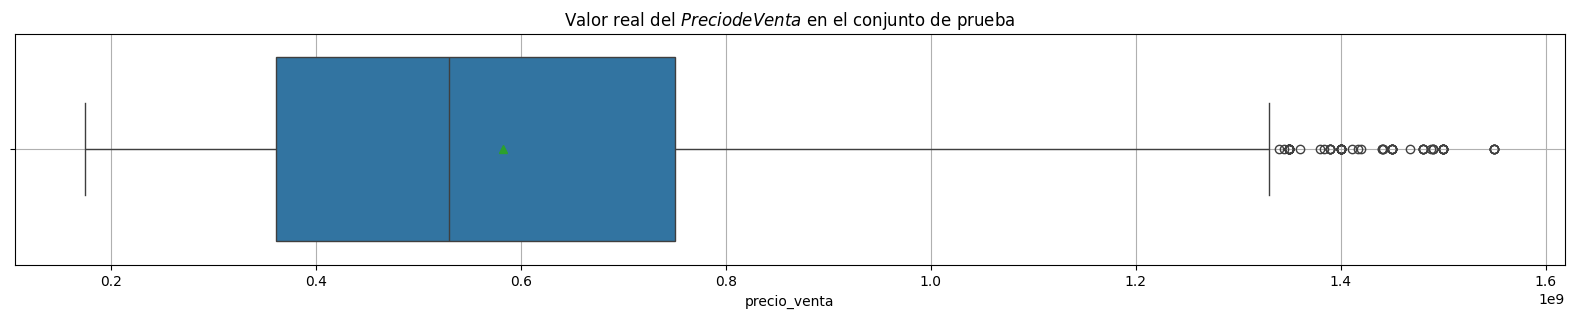

In [70]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real del $\t{Precio de Venta}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [71]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

,precio_venta
count,4508.00
mean,582549356.90
std,286171371.69
min,175000000.00
25%,360600000.00
50%,530000000.00
75%,750000000.00
99%,1400000000.00
max,1550000000.00


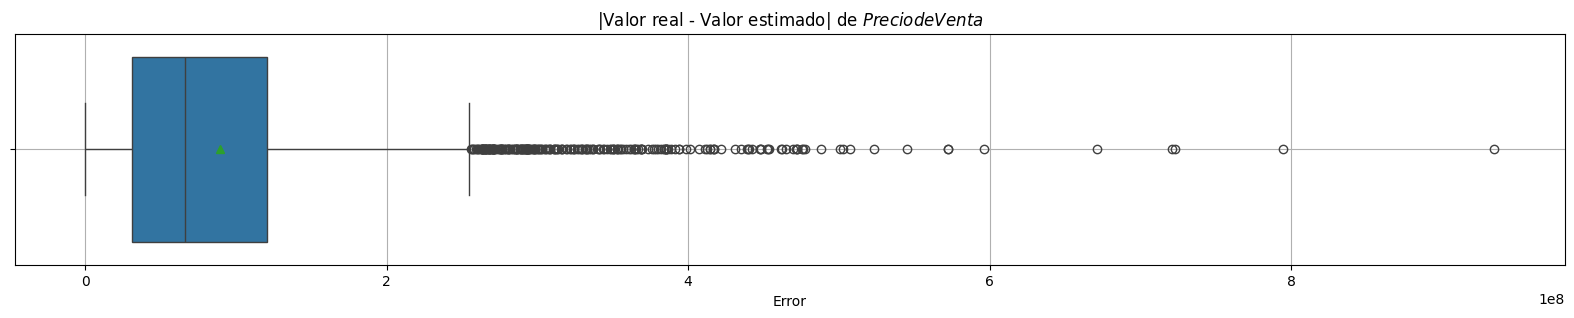

In [72]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Precio de Venta}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [73]:
abs(y_test-regression.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,precio_venta
count,4508.00
mean,89289518.91
std,84653365.09
min,33483.36
25%,30997627.16
50%,66501927.16
75%,120717627.69
95%,257632586.17
99%,400748825.73
max,934963842.60


Las métricas de error para el dataset de entrenamiento y prueba son muy similares. Para el conjunto de prueba los valores de la variable objetivo están centrados en 582'550.00 COP con una desviacion estandar de 286'000.000, mientras que el 75% de los errores de estimación del modelo se encuentran por debajo de 120'717.627 COP,  por debajo de una desviación estándar, sin embargo es un valor muy alto para un error de estimacion dado el contexto.

## **6. Entrenamiento de un segundo modelo aplicando normalización**

In [74]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [75]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [76]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

,columns,coef
0,area,170212627.83
1,habitaciones,-22336095.39
2,banos,15346671.15
3,administracion,61315169.92
4,parqueaderos,18378246.82
5,estrato,40367269.03
6,jacuzzi,1093552.01
7,gimnasio,16780914.81
8,ascensor,-2065202.69
9,piscina,5770796.91


In [77]:
pipeline["model"].intercept_

580686377.2814759

In [78]:
y_train.mean(), y_test.mean()

(580686377.2814759, 582549356.9001775)

In [79]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

MAE:
Train: 88940106.90997568
Test: 89289518.91272058

RMSE:
Train: 121626324.35766038
Test: 123033413.132626


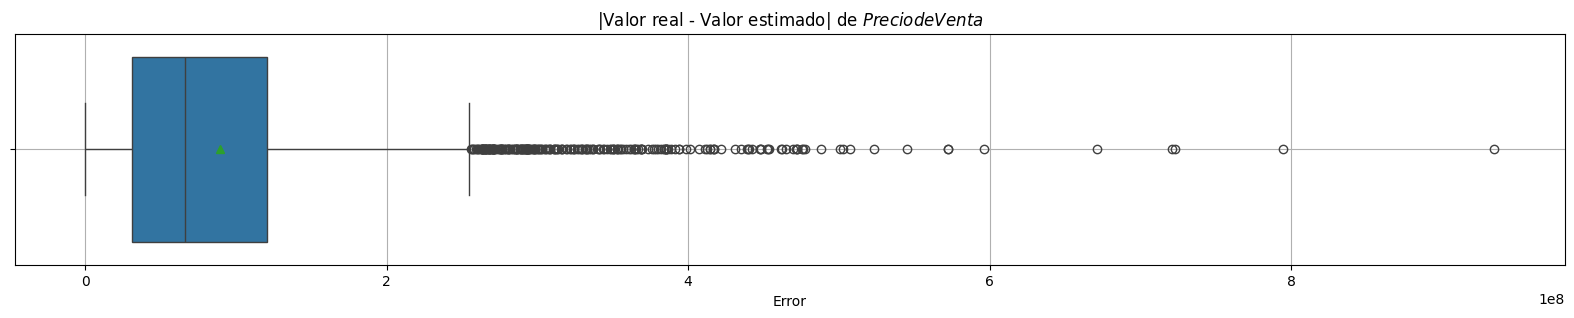

In [80]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - pipeline.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Precio de Venta}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [81]:
abs(y_test-pipeline.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,precio_venta
count,4508.00
mean,89289518.91
std,84653365.09
min,33483.36
25%,30997627.16
50%,66501927.16
75%,120717627.69
95%,257632586.17
99%,400748825.73
max,934963842.60


Las métricas de error para el conjunto de entrenamiento y prueba, son similares, sin embargo aumentaron con respecto a los resultados del primer modelo (antes de la normalizacion).Una vez realizado el proceso de normalización de las variables de entrada, se hace comparable el impacto de sus coeficientes y se evidencia que el area es la variable con mayor impacto positivo sobre la estimacion del precio de venta de un apartamento seguida de la administracion y el estrato. Por el contrario, la variable que mayor impacto negativo tiene sobre la estimacion del precio es en general la antiguedad y mayor antiguedad menor precio. De las variables positivas con respecto a la estimacion de precio, la que menor impacto tiene es: Jacuzzi. De las variables negativas con respecto a la estimacion de precio, la que menor impacto tiene es: Terraza. El valor del intercepto ahora es de 580'686.377 COP lo que corresponde al valor promedio de un apartamento, lo cual es coherente con la media del precio de venta en el conjunto de prueba 582'549.356

## **7. Validación de supuestos de la regresión**


### **7.1. Colinealidad**


<Axes: >

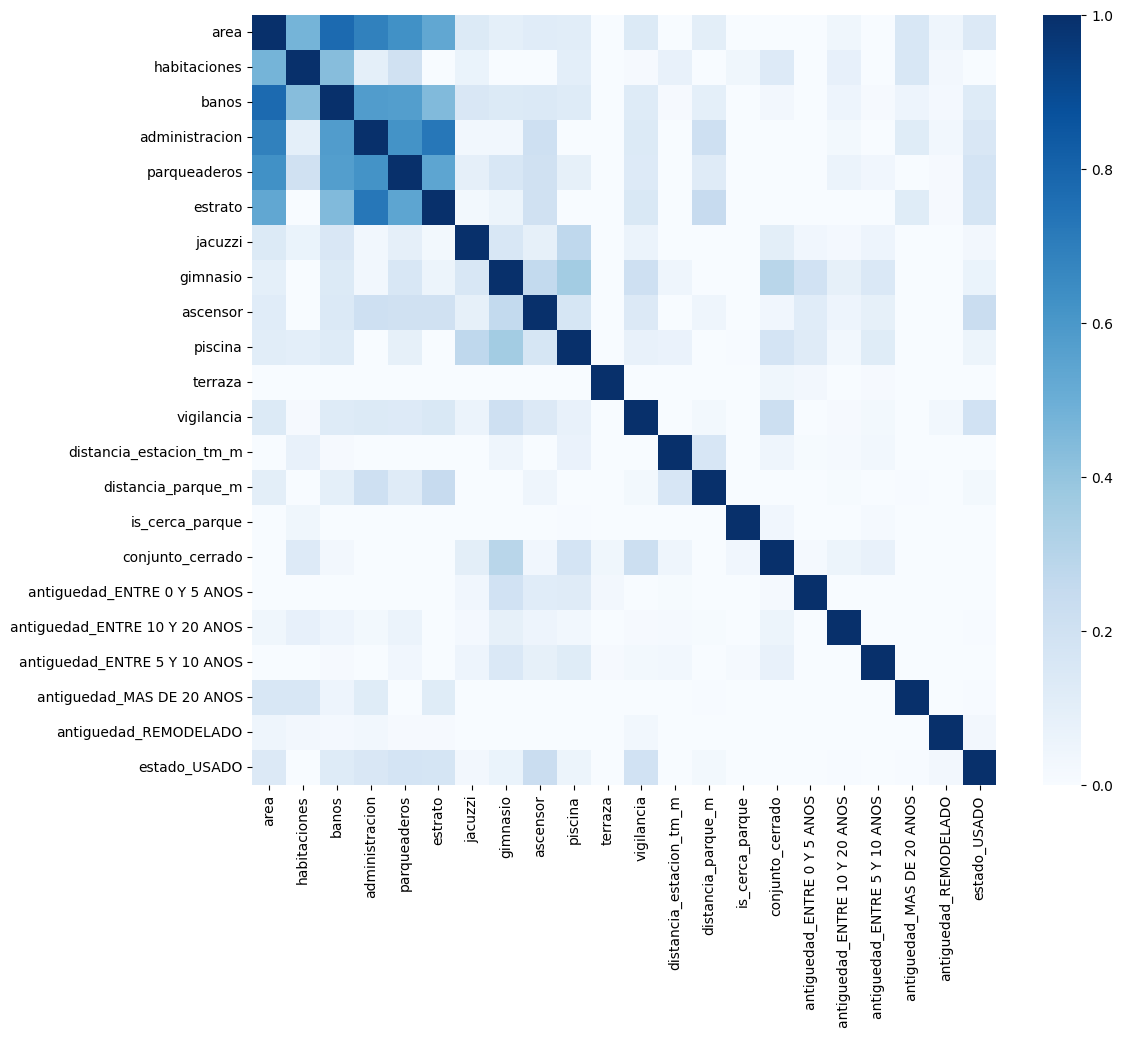

In [82]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [83]:
X_train.corr()

,area,habitaciones,banos,administracion,parqueaderos,estrato,jacuzzi,gimnasio,ascensor,piscina,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m,is_cerca_parque,conjunto_cerrado,antiguedad_ENTRE 0 Y 5 ANOS,antiguedad_ENTRE 10 Y 20 ANOS,antiguedad_ENTRE 5 Y 10 ANOS,antiguedad_MAS DE 20 ANOS,antiguedad_REMODELADO,estado_USADO
area,1.00,0.47,0.78,0.69,0.63,0.53,0.13,0.09,0.11,0.11,-0.03,0.14,0.00,0.10,-0.06,-0.01,-0.22,0.04,-0.04,0.16,0.04,0.14
habitaciones,0.47,1.00,0.43,0.10,0.20,-0.10,0.06,0.00,-0.07,0.10,-0.01,0.01,0.08,-0.06,0.04,0.13,-0.26,0.08,-0.04,0.16,0.03,0.00
banos,0.78,0.43,1.00,0.58,0.57,0.45,0.15,0.14,0.14,0.13,-0.03,0.13,0.01,0.09,-0.05,0.03,-0.15,0.05,0.01,0.05,0.02,0.13
administracion,0.69,0.10,0.58,1.00,0.62,0.72,0.03,0.03,0.21,-0.02,-0.03,0.14,-0.04,0.21,-0.10,-0.13,-0.16,0.02,-0.02,0.12,0.03,0.15
parqueaderos,0.63,0.20,0.57,0.62,1.00,0.54,0.09,0.16,0.20,0.09,-0.03,0.13,-0.02,0.12,-0.07,-0.03,-0.11,0.06,0.04,-0.00,0.01,0.18
estrato,0.53,-0.10,0.45,0.72,0.54,1.00,0.03,0.06,0.20,-0.03,-0.03,0.15,-0.01,0.25,-0.13,-0.16,-0.11,-0.01,-0.03,0.12,0.01,0.18
jacuzzi,0.13,0.06,0.15,0.03,0.09,0.03,1.00,0.16,0.09,0.27,-0.01,0.06,-0.00,-0.01,0.00,0.10,0.04,0.02,0.05,-0.09,-0.01,0.03
gimnasio,0.09,0.00,0.14,0.03,0.16,0.06,0.16,1.00,0.26,0.36,-0.01,0.21,0.05,-0.02,-0.02,0.29,0.19,0.09,0.15,-0.33,-0.08,0.07
ascensor,0.11,-0.07,0.14,0.21,0.20,0.20,0.09,0.26,1.00,0.16,-0.06,0.14,-0.00,0.05,-0.03,0.04,0.12,0.05,0.09,-0.20,-0.03,0.23
piscina,0.11,0.10,0.13,-0.02,0.09,-0.03,0.27,0.36,0.16,1.00,-0.01,0.08,0.07,-0.05,0.00,0.18,0.12,0.03,0.12,-0.21,-0.04,0.05


Como se observo anteriormente, existe una baja correlacion entre las variables de entrada. Es decir, el presente modelo cumple con el principio de NO COLINEALIDAD.

### **7.2. Linealidad**

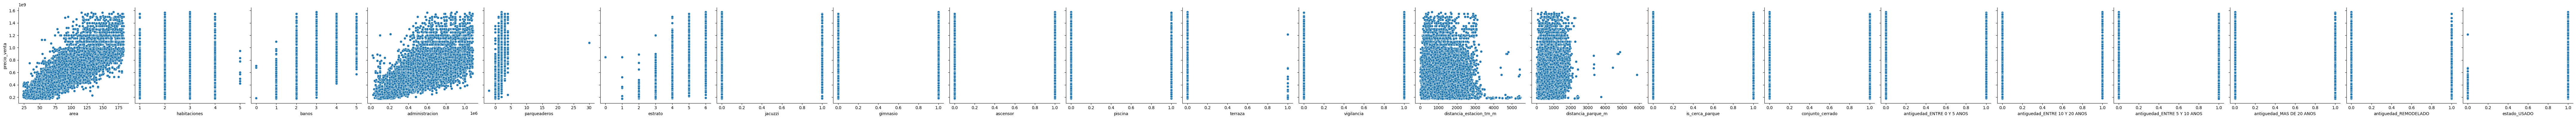

In [84]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="precio_venta", x_vars=features, kind="scatter")

De acuerdo a las graficas de correlacion entre las variables y el precio de venta, el area y la administracion son las unicas variables que tienen una relacion lineal con el precio. Teniendo en cuenta lo anterior, el presente modelo NO CUMPLE con el principio de linealidad.

### **7.3. Normalidad de los errores**


In [85]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [86]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [87]:
errors = (pipeline.predict(X_train[features])-y_train).values

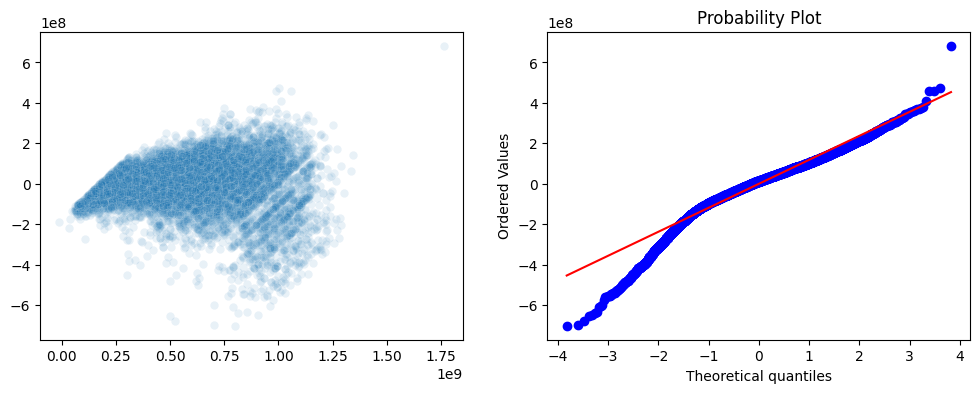

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[features]), y=errors, alpha=0.1, ax=axes[0])
# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

El error no presenta una distribucion normal, de acuerdo a la grafica es posible que presente una subestimacion por los valores negativos que presenta.

### **7.4 Varianza constante (Homocedasticidad)**

<Axes: >

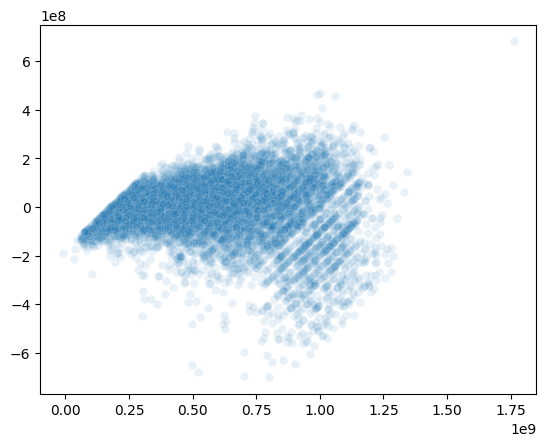

In [89]:
sns.scatterplot(x = pipeline.predict(X_train[features]), y=errors, alpha=0.1)

## **9. Interpretabilidad**

Se entrenó un modelo de regresion lineal OLS para poder calcular mas facilmente los coeficientes, el error estandar y la estadistica t. Los valores de los coeficientes del modelo de regresion lineal normalizado ejecutado inicialmente son iguales a los del modelo de regresion lineal OLS.

In [112]:
# Clase definida para encapsular el comportamiento de entrenamiento y prediccion
class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        X_with_const = sm.add_constant(X)
        self.model_ = sm.OLS(y, X_with_const).fit()
        return self

    def predict(self, X):
        X_with_const = sm.add_constant(X)
        return self.model_.predict(X_with_const)


In [113]:
# Se ejecuta el pipeline para normalizacion de las variables de entrada
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", StatsmodelsOLS())
    ]
)

In [114]:
# Se entrena el modelo previa estandarizacion de las variables de entrada
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', StatsmodelsOLS())])

In [127]:
# Se crea un dataframe con los coefientes, el error estandar y la estadistica t del modelo de regresion OLS
feature_names_=['area', 'habitaciones', 'banos', 'administracion', 'parqueaderos', 'estrato', 'jacuzzi', 'gimnasio', 'ascensor', 'piscina', 'terraza', 'vigilancia', 'distancia_estacion_tm_m', 'distancia_parque_m', 'is_cerca_parque', 'conjunto_cerrado', 'antiguedad_ENTRE 0 Y 5 ANOS', 'antiguedad_ENTRE 10 Y 20 ANOS', 'antiguedad_ENTRE 5 Y 10 ANOS', 'antiguedad_MAS DE 20 ANOS', 'antiguedad_REMODELADO', 'estado_USADO']
model = pipeline["model"].model_
results = pd.DataFrame({
    'Coefficient': model.params,
    'SE': model.bse,
    '|t|': abs(model.tvalues)
})
results.index = ['const'] + feature_names_
results = results.drop(index='const')

print(results.sort_values(by='|t|', ascending=False))

                               Coefficient          SE   |t|
area                          170212627.83  2431788.44 69.99
administracion                 61315169.92  2128606.66 28.81
estrato                        40367269.03  1912745.15 21.10
habitaciones                  -22336095.39  1631808.43 13.69
gimnasio                       16780914.81  1431767.87 11.72
parqueaderos                   18378246.82  1687131.17 10.89
distancia_estacion_tm_m       -11214702.50  1219824.92  9.19
banos                          15346671.15  1973081.53  7.78
conjunto_cerrado               -6544009.40  1329267.45  4.92
piscina                         5770796.91  1344009.46  4.29
is_cerca_parque                 6513241.82  1601271.63  4.07
antiguedad_MAS DE 20 ANOS     -90411215.02 28888209.92  3.13
distancia_parque_m             -3733657.58  1661198.61  2.25
antiguedad_REMODELADO         -23046406.55 10753516.52  2.14
antiguedad_ENTRE 10 Y 20 ANOS -54394725.05 27070163.67  2.01
antiguedad_ENTRE 5 Y 10 

De acuerdo al valor de la estadistica t, el **area** es la variable de entrada con mayor significancia estadistica, seguida de la **administracion** y el **estrato**. Se confirma tambien la significacia estadistica para la variable **habitaciones**, la cual tiene un impacto negativo sobre la estimacion del precio de venta de un apartamento.

## **9.1 Grafico de pesos y estimacion de la varianza**

In [128]:
def plot_results(results):
  plt.figure(figsize=(10, 12))

  plt.barh(results.index, results['Coefficient'], xerr=results['SE'], capsize=5, color='skyblue', edgecolor='k')

  # Add a vertical reference line at 0 for interpreting significance
  plt.axvline(0, color='gray', linestyle='--')
  plt.ylabel("Variables")
  plt.xlabel("Coefficient (± SE)")
  plt.title("Grafico de pesos (Coeficientes) con estimacion de la varianza (Error Estandar)")
  plt.tight_layout()
  plt.show()


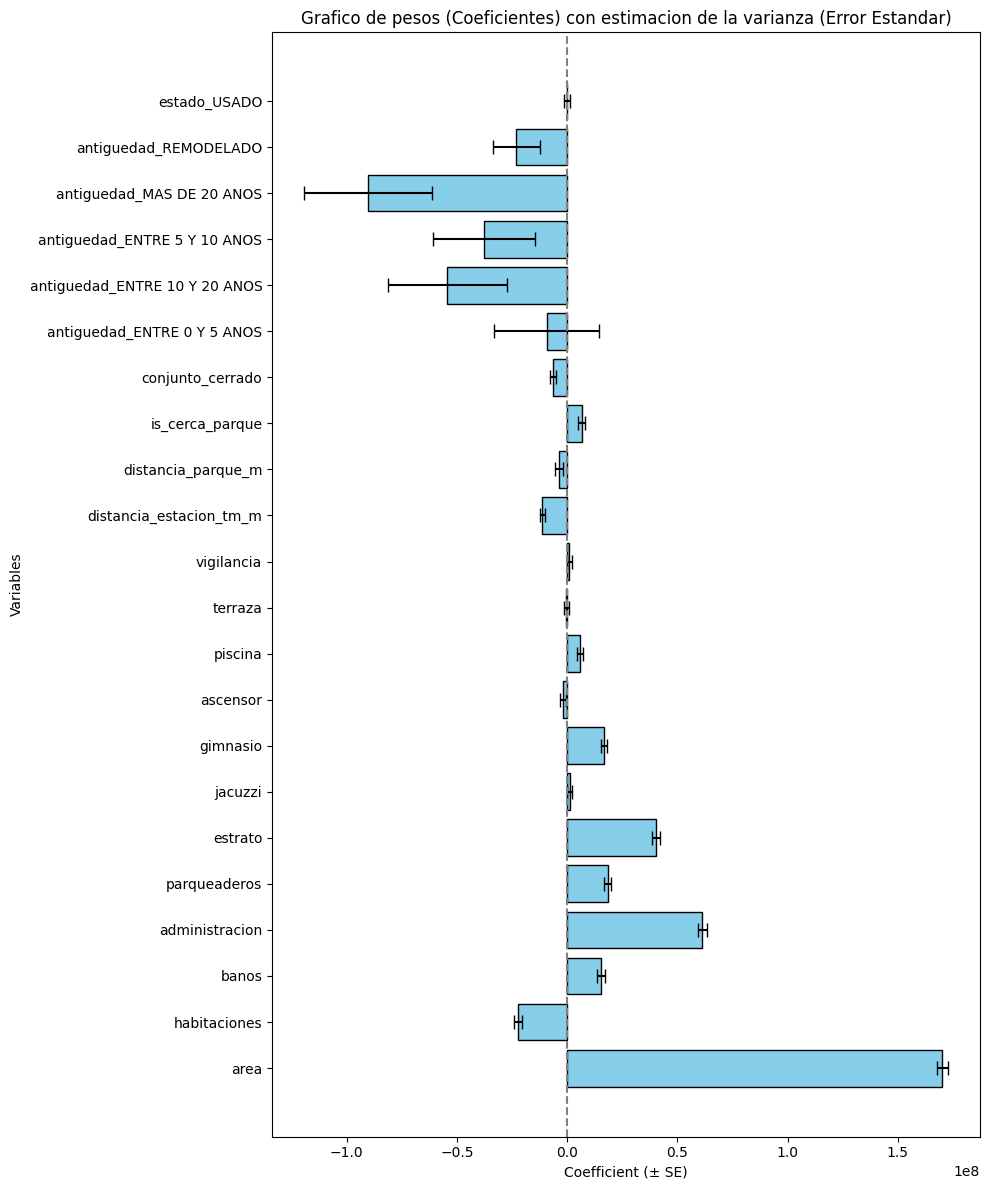

In [129]:
plot_results(results)

Se observa que las variables de **Antiguedad** son las que mayor impacto negativo tienen sobre la estimacion del precio de venta dado el valor de su coeficiente y tambien presentan una mayor varianza dado el error estandar, todas las variables que tienen un impacto positivo (area, baños, parqueaderos, administracion, estrato) sobre la estimacion del precio de venta tienen un error estandar menor con respecto a las variables de impacto negativo.

## **9.2 Grafico de Efectos**

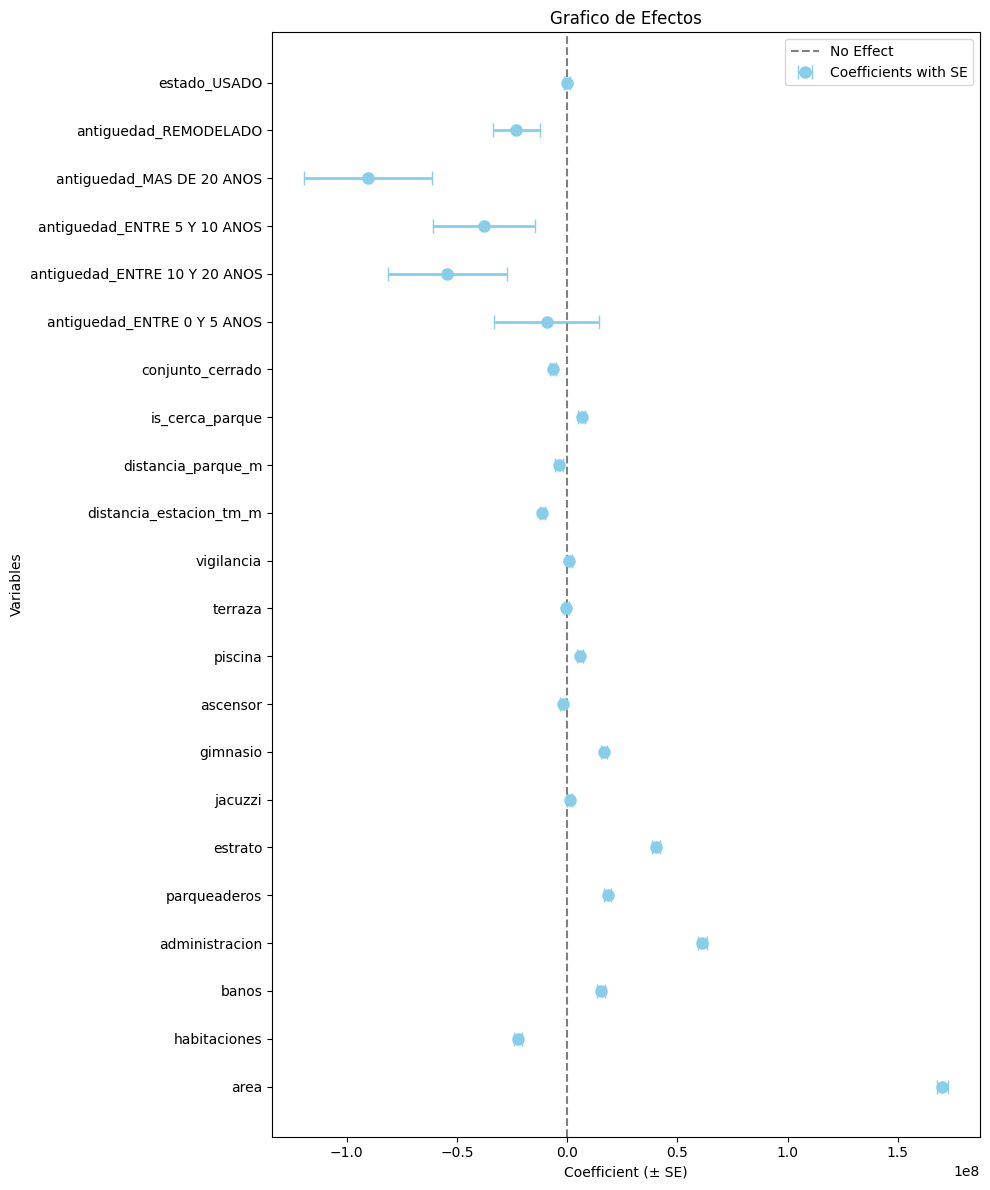

In [130]:
# Create a dot plot
def dot_plot(df):
  plt.figure(figsize=(10, 12))
  plt.errorbar(df['Coefficient'], df.index, xerr=df['SE'], fmt='o', color='skyblue',
              markersize=8, capsize=5, elinewidth=2, label='Coefficients with SE')

  plt.axvline(0, color='gray', linestyle='--', label='No Effect')

  # Labels and title
  plt.xlabel("Coefficient (± SE)")
  plt.ylabel("Variables")
  plt.title("Grafico de Efectos")
  plt.legend()
  plt.tight_layout()
  plt.show()

dot_plot(results)